<a href="https://colab.research.google.com/github/smara97/FakeNews/blob/master/liarplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files,drive

from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from torch.autograd import Variable
from string import punctuation
from gensim.models import Word2Vec

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import collections
import nltk
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
import string

nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
""" Model to Training Data 

  Forward Function
Take length of Embedding and Dim of it and Create Embedding Layer by torch Framework
Create Neural Network Layer take 903 input and return 256 as output layer
then bass output to non-activation function layer then add dropout to output
bass output to Linear take 256 and return number of class 1 and then add sigmoid to output

  Conv Function 
Take inputs ( self, inputs layer[batch size of training inputs*Featuers] (64,1440) )

conv inputs layer from [64,1440] to [64,903]

first 300s number repersent the vector sentence(Statement) of Embedding

301 add Similarity of Statement Featuer (first [410] numbers of orignal input) and 
  Subject Featuer (second [30] numbers of orignal input)

from 302 to 602 add number repersent the vector sentence(Subject) of Embedding

602 add Similarity of Subject Featuer ([30] numbers of orignal input) and 
  Justification Featuer (second [1000] numbers of orignal input)

from 602 to 902 add number repersent the vector sentence(Justifaction) of Embedding

903 add Similarity of Justification Featuer ([100] numbers of orignal input) and 
  Statement Featuer (second [410] numbers of orignal input)

and return [64,903]

Then Pass output of Conv to Forward


"""

class NN(nn.Module):


  def __init__(self, vocab_size, embedding_dim):

    super(NN, self).__init__()

        
    self.embedding = nn.Embedding(vocab_size, embedding_dim)   
    

    self.fc = nn.Linear(903, 512)
    self.relu1=nn.ReLU()
    self.dropout1=nn.Dropout(0.4)
    self.fc2=nn.Linear(512,128)
    self.relu2=nn.ReLU()
    self.dropout2=nn.Dropout(0.4)
    self.fc3=nn.Linear(128,1)
    self.sig = nn.Sigmoid()


  def forward(self, x):

    batch_size = x.size(0)

    x = self.conv(x)

    out = self.dropout1(self.relu1(self.fc(x)))
    out = self.dropout2(self.relu2(self.fc2(out)))
    out=self.sig(self.fc3(out))
    return out
    
  def conv(self,x):
    batch=len(x)

    ret=torch.zeros((batch,903)).cuda()
    st=torch.zeros(300).cuda()
    su=torch.zeros(300).cuda()
    ju=torch.zeros(300).cuda()


    
    for i in range(batch):
  
      st=self.embedding(x[i][0:411]).sum(dim=0)/(x[i][0:411]!=0).sum()
      su=self.embedding(x[i][411:441]).sum(dim=0)/(x[i][411:441]!=0).sum()
      ju=self.embedding(x[i][441:1440]).sum(dim=0)/(x[i][441:1440]!=0).sum()
      
      ret[i][:300]=st
      ret[i][300]=simlarity(st,su)

      ret[i][301:601]=su
      ret[i][601]=simlarity(su,ju)

      ret[i][602:902]=ju
      
      ret[i][902]=simlarity(st,ju)
    return ret
      

In [0]:
"""
 Read Glove File take url of file return the two dictionaries ( word to index and word to vector in embedding )
 and one list of index to word  
 (glove file url) --> words_to_index, index_to_words, word_to_vec_map
 
 """

def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
"""
Word Embeddings of words take dictionary of word to embedding and word to index
and return Embeddings Matrix [index,Embedding] 

"""

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1
    emb_matrix = np.zeros((vocab_len,300))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    return emb_matrix

In [0]:
"""
Clean Text 

"""

def clean(text):
  text=text.lower()
  stp=set(stopwords.words("english"))
  placesp = re.compile('[/(){}\[\]\|@,;]')
  removech= re.compile('[^0-9a-z #+_]')
  st=WordNetLemmatizer()
  text=re.sub(placesp,' ',text)
  text=re.sub(removech,' ',text)
  text=text.split()
  text=[w for w in text if not w in stp]
  text=[st.lemmatize(w) for w in text]
  text=" ".join(text)
  text = text.translate(str.maketrans("", "", string.punctuation))
  return text

In [0]:
"""
Transfer sentence to indeces word in Embedding
take text and word to index dictionary 
return list of indeces word in Embedding

"""
def transfer_sent(text,word_to_index):
  text=text.split(' ')
  ret=[]
  for w in text:
    if w in word_to_index and w !="":
      ret.append(word_to_index[w])
  return ret

In [0]:
"""
Similarity of two Documnets 
take two documnets
return The Similarity of documents

"""

def simlarity(dim1,dim2):
  return (torch.dot(dim1,dim2)/(torch.sqrt(torch.sum(dim1**2))*torch.sqrt(torch.sum(dim2**2))))

In [0]:
"""
Accuracy of predict labels
take predict labels and target labels
return number of accept label in predict labels

"""

def Accu(pred,labels):
  ret=0
  for i in range(len(labels)):
    if pred[i]==labels[i]:
      ret+=1
  return ret/len(labels)

In [0]:
"""
calculate the Max Length in every column in Data Frame 
take Data Frame 
return Max lenght of columns

"""

def retmax(dftrain):

  stmax,sumax,jumax=0,0,0
  for i in range(dftrain.shape[0]):

    stmax=max(stmax,len(np.array(dftrain.loc[i,'statement'])))

    sumax=max(sumax,len(np.array(dftrain.loc[i,'subject'])))

    jumax=max(jumax,len(np.array(dftrain.loc[i,'justification'])))

  return stmax,sumax,jumax


In [0]:
"""
Convert Data Frame to Matrix 2D by Adding padding zeros to every columns that not have lenght not equal max
lenght.
take Data Frame list of Max Lenghts of Columns
return Matrix after convert

"""

def convert2D(Xs,max_lens):
   X_indices = np.zeros((Xs[0].shape[0], sum(max_lens)))
   pls=0

   for i in range(Xs[0].shape[0]):
     pls=0
     
     for j in range(0,len(Xs[0][i])):
       X_indices[i][j+pls]=Xs[0][i][j]
     pls=max_lens[0]

     for j in range(0,len(Xs[1][i])):
       X_indices[i][j+pls+1]=Xs[1][i][j]
     pls=max_lens[1]+max_lens[0]

     for j in range(0,len(Xs[2][i])):
       X_indices[i][j+pls+1]=Xs[2][i][j]
   return X_indices

In [0]:
"""
convert labels to 0,1 True or False  

"""
convertlabel = {
	'pants-fire': 0,
	'false': 0,
	'barely-true': 0,
	'half-true': 1,
	'mostly-true': 1,
	'true': 1
}

In [0]:
"""
list of columns's Name 

"""

cols=['index','ID','label','statement','subject','speaker',
      'speaker_job','state','party','barely_true',
      'false','half_true','mostly_true','pants_on_fire',
      'context','justification']

In [0]:
"""
Call read_glove_vecs function and then call pretrained_embedding_layer to calc word Embedding of Words

"""

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("/content/drive/My Drive/Datasets/Word Embedding/glove.6B.300d.txt")
word_embedding=pretrained_embedding_layer(word_to_vec_map, word_to_index)


In [0]:
"""
Read Dataset (Data Frame)

"""

dftrain=pd.read_csv("/content/drive/My Drive/Datasets/liar-plus/train.tsv",sep="\t",header=None)
dfval=pd.read_csv("/content/drive/My Drive/Datasets/liar-plus/val.tsv",sep="\t",header=None)
dftest=pd.read_csv("/content/drive/My Drive/Datasets/liar-plus/test.tsv",sep="\t",header=None)

In [0]:
"""
Add list cols to Data Frame columns

"""

dftrain.columns=cols
dfval.columns=cols
dftest.columns=cols

In [0]:
"""
Make Datasets have only statement,subject,justification and label 
important Feauters to Training

"""

dftrain=dftrain.loc[:,['statement','subject','justification','label']]
dfval=dfval.loc[:,['statement','subject','justification','label']]
dftest=dftest.loc[:,['statement','subject','justification','label']]
dftrain=dftrain.append(dfval)
dftrain=dftrain.append(dftest)

In [0]:
"""
Drop NAN value and index column in Datasets 

"""

dftrain=dftrain.dropna(axis=0)

dftrain=dftrain.reset_index()

dftrain=dftrain.drop(['index'],axis=1)


In [19]:
"""  Show first two's row in dataset """

dftrain.head(2)

,statement,subject,justification,label
0,Says the Annies List political group supports ...,abortion,That's a premise that he fails to back up. Ann...,false
1,When did the decline of coal start? It started...,"energy,history,job-accomplishments","Surovell said the decline of coal ""started whe...",half-true


In [0]:
"""
Convert Labels dataset to 0,1 by Call convertlabel Function , 
sentence to indeces by call transfer_sent Function

"""

for i in range(dftrain.shape[0]):
  dftrain.loc[i,'label']=convertlabel[dftrain.loc[i,'label']]
  dftrain.loc[i,'statement']=transfer_sent(clean(dftrain.loc[i,'statement']),word_to_index)
  dftrain.loc[i,'subject']=transfer_sent(clean(dftrain.loc[i,'subject']),word_to_index)
  dftrain.loc[i,'justification']=transfer_sent(clean(dftrain.loc[i,'justification']),word_to_index)

In [0]:
""" Take Labels two make only Target dataset and drop it in orignal dataset """

dftrainy=dftrain['label']

dftrain=dftrain.drop(['label'],axis=1)

In [0]:
"""
Calc Max Lengths in every Columns by call retmax Function ,
convert Data Frame to Matrix by convert2D Function

"""

stmax,sumax,jumax=retmax(dftrain)
Fulldata=np.array(convert2D([dftrain.statement,dftrain.subject,dftrain.justification],[410,30,1000]))


In [0]:
""" Split dataets to Training ,Validation and Testing Datasets """

dftrainy=list(dftrainy)
training,trainingy=Fulldata[:10153],dftrainy[:10153]
validation,validationy=Fulldata[10154:11422],dftrainy[10154:11422]
testing,testingy=Fulldata[11423:],dftrainy[11423:]

In [0]:
""" Convert every Datasets to Torch Datasets """

training=torch.from_numpy(training)
trainingy = torch.tensor(trainingy) 
train_tensor = torch.utils.data.TensorDataset(training, trainingy)

validation=torch.from_numpy(validation)
validationy = torch.tensor(validationy) 
valid_tensor = torch.utils.data.TensorDataset(validation, validationy)

testing=torch.from_numpy(testing)
testingy = torch.tensor(testingy) 
test_tensor = torch.utils.data.TensorDataset(testing, testingy)

In [0]:
""" Create DataLoader to Every Datasets """

train_loader=torch.utils.data.DataLoader(dataset=train_tensor,batch_size=64,shuffle=True, num_workers=0)
vali_loader=torch.utils.data.DataLoader(dataset=valid_tensor,batch_size=64,shuffle=True, num_workers=0)
test_loader=torch.utils.data.DataLoader(dataset=test_tensor,batch_size=64,shuffle=True, num_workers=0)


In [26]:
"""
object from NN Model
and print it
"""
vocab_size = len(word_to_index)+1
embedding_dim = 300
net = NN(vocab_size, embedding_dim)
print(net)

NN(
  (embedding): Embedding(400001, 300)
  (fc): Linear(in_features=903, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [0]:
"""
Learning rate 0.001
create Binary Cross Entropy Loss function
Create Adam optimizer to optimization parameters of NN ( Embedding , Linear Layers )

"""
lr=0.001

net.cuda()
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [28]:
""" 10 Number Epoch """

LtraininVis,LvalidVis=[],[]

epochs = 10

net.train() 

for e in range(epochs):

  Taccuracy,Vaccuracy=[],[]
  losses=[]
  
  for inputs, labels in train_loader:

    inputs, labels = inputs.cuda(), labels.cuda()  

   
    net.zero_grad()
    
    output= net(inputs.long())

    Taccuracy.append(Accu(torch.round(output),labels))

    torch.autograd.set_detect_anomaly(True)

    loss = criterion(output.squeeze().float(), labels.float())

    loss = Variable(loss, requires_grad = True)

    losses.append(loss.item())

    loss.backward()

    optimizer.step()
   


  with torch.no_grad():

    net.eval()
    val_losses = []
  
    for inputs, labels in vali_loader:

      inputs, labels = inputs.cuda(), labels.cuda()

      output= net(inputs.long())

      Vaccuracy.append(Accu(torch.round(output),labels))

      val_loss = criterion(output.squeeze(), labels.float())

      val_losses.append(val_loss.item())

    net.train()

    LtraininVis.append(np.mean(losses))
    LvalidVis.append(np.mean(val_losses))
    print("Epoch: {}/{}...".format(e+1, epochs),
          "Tarining Loss: {:.6f}...".format(np.mean(losses)),
          "Val Loss: {:.6f}".format(np.mean(val_losses)),
          "Val Accu:{:.6f}".format(np.mean(Vaccuracy)),
          "Training Accu:{:.6f}".format(np.mean(Taccuracy)))
    

Epoch: 1/10... Tarining Loss: 5.131826... Val Loss: 5.028229 Val Accu:0.520433 Training Accu:0.561115
Epoch: 2/10... Tarining Loss: 5.136190... Val Loss: 5.042068 Val Accu:0.519531 Training Accu:0.563202
Epoch: 3/10... Tarining Loss: 5.110074... Val Loss: 5.018106 Val Accu:0.521154 Training Accu:0.560765
Epoch: 4/10... Tarining Loss: 5.142462... Val Loss: 5.028985 Val Accu:0.519712 Training Accu:0.561287
Epoch: 5/10... Tarining Loss: 5.163537... Val Loss: 5.045313 Val Accu:0.518269 Training Accu:0.560654
Epoch: 6/10... Tarining Loss: 5.130317... Val Loss: 5.040045 Val Accu:0.519171 Training Accu:0.562730
Epoch: 7/10... Tarining Loss: 5.067871... Val Loss: 5.032308 Val Accu:0.519892 Training Accu:0.561453
Epoch: 8/10... Tarining Loss: 5.127976... Val Loss: 5.015590 Val Accu:0.521154 Training Accu:0.562895
Epoch: 9/10... Tarining Loss: 5.132958... Val Loss: 5.019391 Val Accu:0.520793 Training Accu:0.561127
Epoch: 10/10... Tarining Loss: 5.182994... Val Loss: 5.028284 Val Accu:0.519892 Tr

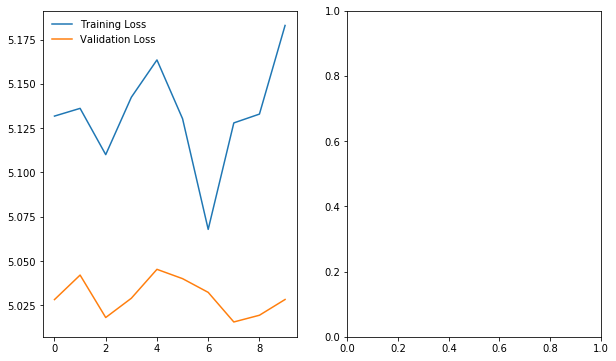

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(LtraininVis,label='Training Loss')
ax1.plot(LvalidVis,label='Validation Loss')

ax1.legend(frameon=False)
